In [12]:
using Plots, Statistics, NaNStatistics, LinearAlgebra, Serialization, ParticleFilters

include("./utils/import.jl")
include("./utils/figs.jl")
using .Import
using .Figs

Figs.foo()
Import.bar()




In [24]:
struct State
    u::Array{Float64}         # list of N utility values for N items
    d::Array{Array{Float64}}  # list of K arm distributions, each assigning probabilities to N items
    b::Array{Float64}         # list of M beta values
end

actions = ["C1", "C2", "C3", "B1", "B2"]

5-element Vector{String}:
 "C1"
 "C2"
 "C3"
 "B1"
 "B2"

In [62]:
#### UTILS ####

function parse_state(s::String)
    sp = split(s, ['{', '}'])

    u_str = split(sp[1], ['[', ']'])[2]
    u = [parse(Float64, x) for x in split(u_str, ", ")]

    spsp = split(sp[3], ['[', ']'])
    d_str = [spsp[3], spsp[5], spsp[7]]
    d = [[parse(Float64, x) for x in split(elem, ", ")] for elem in d_str]

    b_str = spsp[10]
    b = [parse(Float64, x) for x in split(b_str, ", ")]

    return State(u,d,b)
end

function get_optimal_arm(s::State)
    max_arm = -1
    max_val = -1
    for i in 1:length(s.d)
        val_i = dot(s.u, s.d[i])
        if val_i > max_val
            max_arm = i
            max_val = val_i
        end
    end
    return "C"*string(max_arm)
end

function get_star(expID::String, runs::Int)
    lines = []
    run_lines = []
    for run in 1:runs
        run_lines = []
        open("./sims/"*expID*"_run"*string(run)*".txt", "r") do file
            for line in readlines(file)
                push!(run_lines, line)
            end
        end
        push!(lines, run_lines)
    end
    
    sims = [[split(l,',') for l in run_lines[2:end]] for run_lines in lines]

    s = [parse_state(l[1]) for l in lines]
    t = [[parse(Int64, s[1]) for s in sim] for sim in sims]
    a = [[s[3] for s in sim] for sim in sims]
    r = [[parse(Float64, s[end]) for s in sim] for sim in sims]
    
    return s,t,a,r
end

function print_action_hist(a::Vector{Vector{SubString{String}}})
    first_action_hist = zeros(5)
    second_action_hist = zeros(5)
    third_action_hist = zeros(5)
    fourth_action_hist = zeros(5)

    for ai in a
        for i in 1:length(actions)
            if ai[1] == actions[i]
                first_action_hist[i] = first_action_hist[i] + 1
            end
            if ai[2] == actions[i]
                second_action_hist[i] = second_action_hist[i] + 1
            end
            if ai[3] == actions[i]
                third_action_hist[i] = third_action_hist[i] + 1
            end
            if ai[4] == actions[i]
                fourth_action_hist[i] = fourth_action_hist[i] + 1
            end
        end
    end

    println("First Action")
    for i in 1:length(actions)
        println(actions[i], ":\t", first_action_hist[i])
    end

    println("\nSecond Action")
    for i in 1:length(actions)
        println(actions[i], ":\t", second_action_hist[i])
    end

    println("\nThird Action")
    for i in 1:length(actions)
        println(actions[i], ":\t", third_action_hist[i])
    end
end

function plot_avg_r(r::Vector{Vector{Float64}}, granularity::Int)
    # calc avg r over range
    @assert length(r[1])%granularity == 0

    points = floor(Int, t[1][end]/granularity)
    timesteps = zeros(points)
    avg_r = zeros((runs, points))
    for i in 1:points
        en = i*granularity
        st = en-(granularity-1)
        for run in 1:runs
            avg = mean(r[run][st:en])
            timesteps[i] = i*granularity
            avg_r[run,i] = avg
        end
    end

    avg_r_array = [vec(avg_r[i,:]) for i in 1:(size(avg_r)[1])]

    # plot avg r v. timestep
    plot(timesteps, avg_r_array,
        ylims = (0,10),
        ylabel = "reward (avg over "*string(granularity)*" steps)",
        xlabel = "timestep",
        legend = false,
        title = "avg reward, y="*string(y)*" (exp "*expID*", "*string(runs)*" runs)")
end

function plot_proportion_actions_in_list(a::Vector{Vector{SubString{String}}}, a_list::Array{String}, gran::Int)
    @assert length(a[1])%gran == 0
    
    valid_a = [[arm in a_list for arm in a[i]] for i in 1:runs]
    
    n = floor(Int, t[1][end]/gran)
    timesteps = zeros(n)
    percent_valid = zeros((runs, n))
    for i in 1:n
        f = i*gran
        s = f-(gran-1)
        timesteps[i] = i*gran
        for run in 1:runs
            percent_valid[run,i] = mean(valid_a[run][s:f])
        end
    end
    
    avg_percent_valid = [mean(percent_valid[:,i]) for i in 1:n]
    sd_percent_valid = [std(percent_valid[:,i]) for i in 1:n]
    
    # plot percent valid actions v. timestep
    plot(timesteps, avg_percent_valid,
        ribbon = sd_percent_valid,
        ylims = (0,1.2),
        ylabel = "% a in "*string(a_list)*" ("*string(gran)*" steps)" ,
        xlabel = "timestep",
        legend = false,
        title = "actions, y="*string(y)*" (exp "*expID*", "*string(runs)*" runs)")
end
                    
function plot_proportion_actions_in_list_rolling(a, a_list::Array{String}, window::Int)
    time = length(a[1])
    @assert time/window >= 2
    
    valid_a = [[arm in a_list for arm in a[i]] for i in 1:runs]
    avg_valid_a = [mean([x[i] for x in valid_a]) for i in 1:time]
    sd_valid_a = [std([x[i] for x in valid_a]) for i in 1:time]
    
    avg_moving_window_percent_valid = [i < window ? mean(avg_valid_a[begin:i]) : mean(avg_valid_a[i-window+1:i]) for i in 1:length(avg_valid_a)]
    sd_moving_window_percent_valid = [i < window ? mean(sd_valid_a[begin:i]) : mean(sd_valid_a[i-window+1:i]) for i in 1:length(sd_valid_a)]

    # plot percent valid actions v. timestep
    plot(1:t[1][end], avg_moving_window_percent_valid,
#         ribbon = sd_moving_window_percent_valid,
        ylims = (0,1.2),
        ylabel = "% a in list "*string(a_list)*" ("*string(window)*" window)" ,
        xlabel = "timestep",
        legend = false,
        title = "actions, y="*string(y)*" (exp "*expID*", "*string(runs)*" runs)")
end
                                        
function get_proportion_actions_in_list_rolling(window::Int, a_list::Array{String})
    @assert t[1][end]/window >= 2
    
    valid_a = [[arm in a_list for arm in a[i]] for i in 1:runs]
    avg_valid_a = [mean([x[i] for x in valid_a]) for i in 1:t[1][end]]    
    avg_moving_window_percent_valid = [i < window ? mean(avg_valid_a[begin:i]) : mean(avg_valid_a[i-window+1:i]) for i in 1:length(avg_valid_a)]

    return avg_moving_window_percent_valid
end

function plot_proportion_actions_all(a, actions, window)
    avg_percent_action = Array{Array{Float64}}(undef, length(actions))
    for i in 1:length(actions)
        avg_percent_action[i] = get_proportion_actions_in_list_rolling(100, [actions[i]])
    end
    plot(1:t[1][end], avg_percent_action,
        ylims = (0,1.0),
        ylabel = "% a ("*string(window)*" step window)" ,
        labels = ["C1" "C2" "C3" "B1" "B2"],
        title = "actions, y="*string(y)*" (exp "*expID*", "*string(runs)*" runs)",
        xlabel = "timestep")
end

function plot_proportion_high_B(a, gran::Int)
    @assert length(a[1])%gran == 0
    
    b_list = ["B1", "B2"]
    
    any_b = [[arm in b_list for arm in a[i]] for i in 1:runs]
    high_b = [[arm == "B2" for arm in a[i]] for i in 1:runs]

    n = floor(Int, length(a[1])/gran)
    timesteps = zeros(n)
    percent_high_B = zeros((runs, n))
    for i in 1:n
        f = i*gran
        s = f-(gran-1)
        timesteps[i] = i*gran
        for run in 1:runs
            times_any_B = sum(any_b[run][s:f])
            times_high_B = sum(high_b[run][s:f])
            percent_high_B[run,i] = times_high_B/times_any_B
        end
    end
    
    inter = [percent_high_B[:,i] for i in 1:n]
    # avg non-nan elements on each element of inter
    yplot = [nanmean(q) for q in inter]
    
    plot(timesteps, yplot,
        ylims = (0,1.2),
        legend = false,
        title = "% high B, y="*string(y)*" (exp "*expID*", "*string(runs)*" runs)",
        ylabel = "% high B/% any B ( "*string(gran)*" window)",
        xlabel = "timestep")
end
;

In [15]:
expID = "22915_095011"
runs = 20
y = 0.99;

In [16]:
s, t, a, r = get_star(expID, runs);

In [19]:
#for these experiments, all runs have the same start state & optimal action
optimal_action = get_optimal_arm(s[1])

println("State:")
println(string(s[1])*"\n")
println("Optimal Action:")
println(string(optimal_action))

State:
State([0.0, 8.0, 10.0], Array{Float64}[[0.0, 0.0, 1.0], [0.6, 0.0, 0.4], [1.0, 0.0, 0.0]], [0.01, 10.0])

Optimal Action:
C1


In [36]:
typeof(a)

Vector{Vector{SubString{String}}} (alias for Array{Array{SubString{String}, 1}, 1})

In [28]:
print_action_hist(a)

First Action
C1:	8.0
C2:	5.0
C3:	2.0
B1:	1.0
B2:	4.0

Second Action
C1:	5.0
C2:	1.0
C3:	5.0
B1:	5.0
B2:	4.0

Third Action
C1:	3.0
C2:	4.0
C3:	9.0
B1:	3.0
B2:	1.0


In [48]:
window = 100;

100

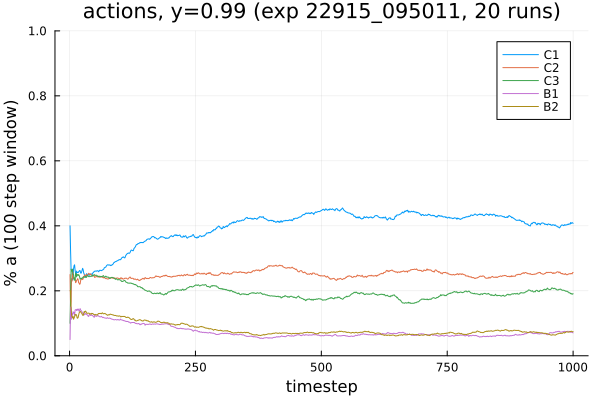

In [49]:
plot_proportion_actions_all(a, actions, window)

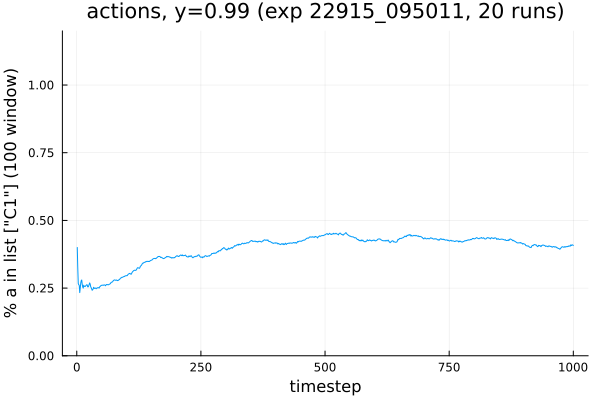

In [52]:
# plot_proportion_actions_in_list(a, [optimal_action], window)
plot_proportion_actions_in_list_rolling(a, [optimal_action], window)

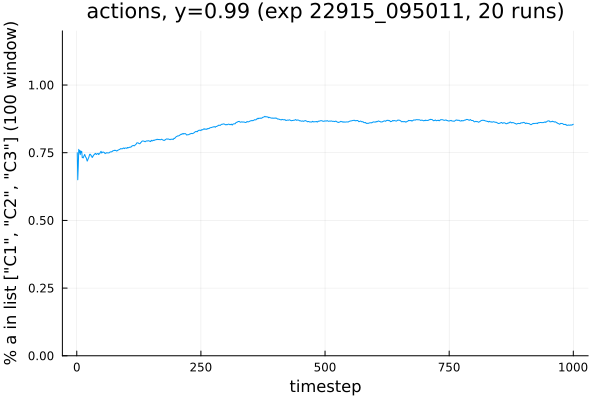

In [53]:
C_actions = ["C1", "C2", "C3"]
# plot_proportion_actions_in_list(a, C_actions, window)
plot_proportion_actions_in_list_rolling(a, C_actions, window)

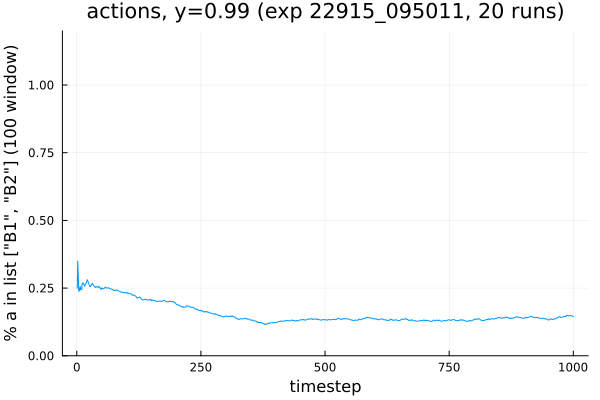

In [54]:
B_actions = ["B1", "B2"]
# plot_proportion_actions_in_list(a, B_actions, window)
plot_proportion_actions_in_list_rolling(a, B_actions, window)

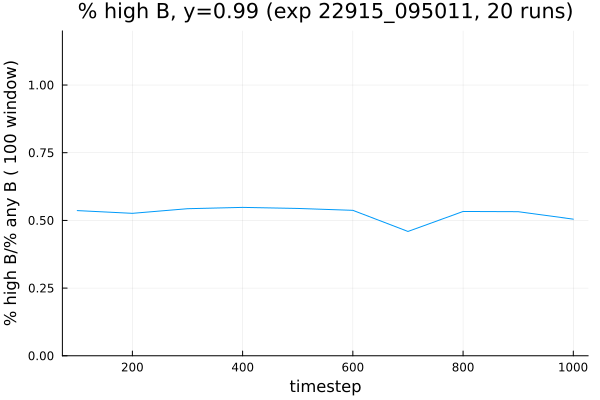

In [63]:
plot_proportion_high_B(a, window)

In [124]:
#### UTILS ####

function get_avg_belief(beliefs::Matrix{Array{ParticleCollection{State}}})
    runs = size(beliefs)[1]
    final_states = [mode(beliefs[run][end]) for run in 1:runs]
    final_state_belief = Array{Array{Float64}}(undef, runs)
    for run in 1:runs
        wt_run = Array{Float64}(undef, length(beliefs[run]))
        for i in 1:length(beliefs[run])
            wt_run[i] = pdf(beliefs[run][i], final_states[run])
        end
        final_state_belief[run] = wt_run
    end
    avg_belief = [mean([x[i] for x in final_state_belief]) for i in 1:t[1][end]]
    return avg_belief
end 

function get_final_states(beliefs::Matrix{Array{ParticleCollection{State}}})
    return [mode(b[end]) for b in beliefs]
end

function print_state(s::State)
    println("\t u: ", s.u)
    println("\t d1: ", s.d[1], "\t (exp val ", dot(s.u, true_state.d[1]), ")")
    println("\t d1: ", s.d[2], "\t (exp val ", dot(s.u, true_state.d[2]), ")")
    println("\t d1: ", s.d[3], "\t (exp val ", dot(s.u, true_state.d[3]), ")")
end

function marginalize_across_d(beliefs::Array{ParticleCollection{State}})
    u_probdicts = Array{Dict}(UndefInitializer(), length(beliefs))

    for i in 1:length(beliefs)
        b = beliefs[i]
        u_probdict = Dict()
        s_probdict = ParticleFilters.probdict(b)
        for s_key in keys(s_probdict)
            u_key = s_key.u
            if u_key in keys(u_probdict)
                u_probdict[u_key] = u_probdict[u_key] + s_probdict[s_key]
            else
                u_probdict[u_key] = s_probdict[s_key]
            end
        end
        u_probdicts[i] = u_probdict
    end
    return u_probdicts
end

function get_avg_belief_marginalized_across_d(beliefs::Matrix{Array{ParticleCollection{State}}})
    runs = size(beliefs)[1]
    final_us = [mode(beliefs[run][end]).u for run in 1:runs]
    final_us_belief = Array{Array{Float64}}(undef, runs)
    for run in 1:runs
        u_probdicts = marginalize_across_d(beliefs[run])
        run_u = final_us[run]
        final_us_belief[run] = [get(prob, run_u, 0) for prob in u_probdicts]
    end
    avg_belief = [mean([x[i] for x in final_us_belief]) for i in 1:t[1][end]]
    return avg_belief
end     

function import_experiment(expID::String)
    println("opening ./beliefs/"*expID*"_belief.txt")
    s, t, a, r = get_star(expID, runs)
    beliefs = deserialize(open("./beliefs/"*expID*"_belief.txt", "r"))
    final_states = [mode(beliefs[run][end]) for run in 1:size(beliefs)[1]]
    avg_belief = get_avg_belief(beliefs)
    avg_belief_u = get_avg_belief_marginalized_across_d(beliefs)
    return s, t, a, r, beliefs, final_states, avg_belief, avg_belief_u
end
;

In [125]:
y8_expID = "22914_23519"
y9_expID = "22915_02260"
y99_expID = "22915_095011"
y999_expID = "22927_082018"

"22927_082018"

In [136]:
@time begin
    println("importing y=0.8 (exp "*y8_expID*") data...")
    y8_s, y8_t, y8_a, y8_r, y8_beliefs, y8_final_states, y8_avg_belief, y8_avg_belief_u = import_experiment(y8_expID)
end;

importing y=0.8 (exp 22914_23519) data...
opening ./beliefs/22914_23519_belief.txt
206.897912 seconds (1.59 G allocations: 61.243 GiB, 4.41% gc time)


In [127]:
@time begin
    println("importing y=0.9 (exp "*y9_expID*") data...")
    y9_s, y9_t, y9_a, y9_r, y9_beliefs, y9_final_states, y9_avg_belief, y9_avg_belief_u = import_experiment(y9_expID)
end;

importing y=0.9 (exp 22915_02260) data...
opening ./beliefs/22915_02260_belief.txt
217.516589 seconds (1.59 G allocations: 61.237 GiB, 7.97% gc time)


In [135]:
println(y8_avg_belief[100] == y999_avg_belief[100])

true


In [129]:
println(get_avg_belief(y8_beliefs)[100] == get_avg_belief(y9_beliefs)[100] )

false


In [131]:
@time begin
    println("importing y=0.99 (exp "*y99_expID*") data...")
    y99_s, y99_t, y99_a, y99_r, y99_beliefs, y99_final_states, y99_avg_belief, y99_avg_belief_u = import_experiment(y99_expID)
end;

importing y=0.99 (exp 22915_095011) data...
opening ./beliefs/22915_095011_belief.txt
207.553019 seconds (1.59 G allocations: 61.241 GiB, 3.30% gc time)


In [ ]:
@time begin
    println("importing y=0.999 (exp "*y999_expID*") data...")
    y999_s, y999_t, y999_a, y999_r, y999_beliefs, y999_final_states, y999_avg_belief, y999_avg_belief_u = import_experiment(y999_expID)
end

In [ ]:
plot(
    1:length(y8_avg_belief),
    [y8_avg_belief, y9_avg_belief, y99_avg_belief, y999_avg_belief],
    labels = ["y=0.8" "y=0.9" "y=0.99" "y=0.999"],
    title = "belief on converged state",
    legend = :bottomright
)

In [91]:
true_state = states[1]

println("\ntrue state")
print_state(true_state)

println("\ny=0.8 final states")
for s in y8_final_states
    println("")
    print_state(s)
end

println("\ny=0.9 final states")
for s in y9_final_states
    println("")
    print_state(s)
end

println("\ny=0.99 final states")
for s in y99_final_states
    println("")
    print_state(s)
end

println("\ny=0.999 final states")
for s in y999_final_states
    println("")
    print_state(s)
end


LoadError: UndefVarError: states not defined

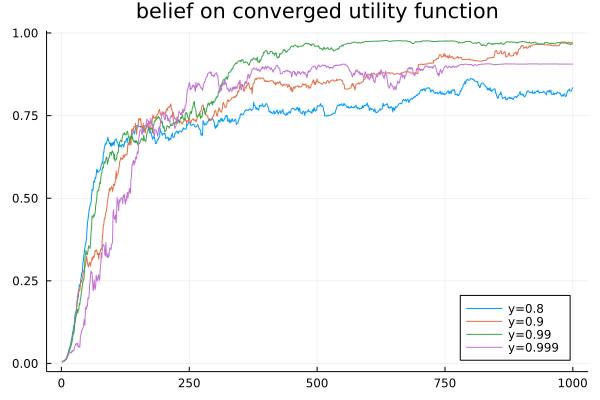

In [392]:
# NOTE: while these are almost identical, they do differ slightly
plot(
    1:length(y8_avg_belief),
    [y8_avg_belief_u, y9_avg_belief_u, y99_avg_belief_u, y999_avg_belief_u],
    labels = ["y=0.8" "y=0.9" "y=0.99" "y=0.999"],
    title = "belief on converged utility function",
    legend = :bottomright
)